,Weight
EARTH_ETF,0.04
YATAI_ETF,0.08
HSHL_ETF,0.08
GLD_ETF,0.30
GUOZAI_ETF,0.20
NASDAQ_ETF,0.20
SPY_ETF,0.10


,Value
Total Annualized Return,0.218242
Total Return,0.739923
Sharpe (Rf=3%),2.056580
Volatility (ann.),0.083125
Max Drawdown,-0.079874
Alpha (annual),0.146918
Beta,0.136992
Trades,4.000000
Win Rate,1.000000
YTD,0.183374



== Yearly Stats ==


,Year,AnnualizedReturn,TotalReturn
0,2023,0.187609,0.193295
1,2024,0.220075,0.228773
2,2025,0.254696,0.183374



== Quarterly Returns (quarter-end only) ==


,Quarter,Return
0,2022Q4,0.000000
1,2023Q1,0.063197
2,2023Q2,0.068774
3,2023Q3,-0.013170
4,2023Q4,0.057293
5,2024Q1,0.073220
6,2024Q2,0.044834
7,2024Q3,0.035615
8,2024Q4,0.053599
9,2025Q1,0.027110



== Quarterly Selected Funds ==


,Quarter,Selected
0,2022Q4,"[EARTH_ETF, YATAI_ETF, HSHL_ETF, GLD_ETF, GUOZ..."
1,2023Q1,"[EARTH_ETF, YATAI_ETF, HSHL_ETF, GLD_ETF, GUOZ..."
2,2023Q2,"[EARTH_ETF, YATAI_ETF, HSHL_ETF, GLD_ETF, GUOZ..."
3,2023Q3,"[EARTH_ETF, YATAI_ETF, HSHL_ETF, GLD_ETF, GUOZ..."
4,2023Q4,"[EARTH_ETF, YATAI_ETF, HSHL_ETF, GLD_ETF, GUOZ..."
5,2024Q1,"[EARTH_ETF, YATAI_ETF, HSHL_ETF, GLD_ETF, GUOZ..."
6,2024Q2,"[EARTH_ETF, YATAI_ETF, HSHL_ETF, GLD_ETF, GUOZ..."
7,2024Q3,"[EARTH_ETF, YATAI_ETF, HSHL_ETF, GLD_ETF, GUOZ..."
8,2024Q4,"[EARTH_ETF, YATAI_ETF, HSHL_ETF, GLD_ETF, GUOZ..."
9,2025Q1,"[EARTH_ETF, YATAI_ETF, HSHL_ETF, GLD_ETF, GUOZ..."



== Trade Records ==


,date,turnover,commission
0,2023-01-03,10000.000000,10.000000
1,2023-01-04,47.877928,0.047878
2,2024-01-03,1343.992570,1.343993
3,2025-01-03,1069.821093,1.069821



== Period Returns (between rebalances) ==


,start,end,return
0,2023-01-03,2023-01-04,0.001063
1,2023-01-04,2024-01-03,0.183980
2,2024-01-03,2025-01-03,0.243241
3,2025-01-03,2025-09-19,0.180780


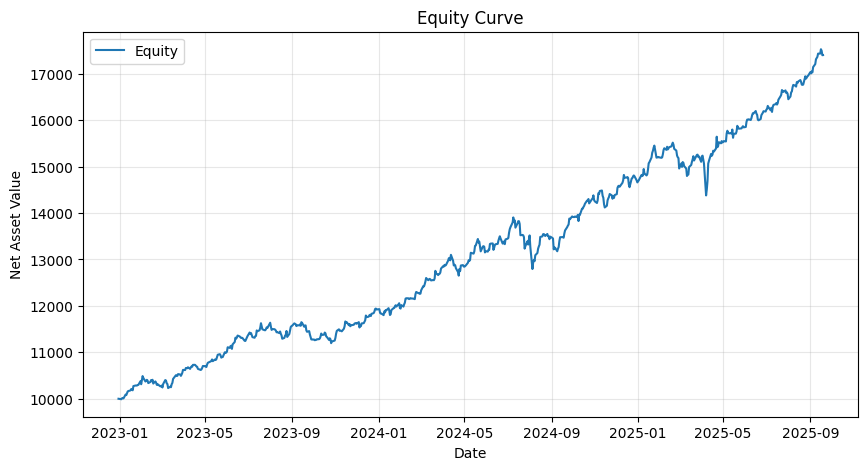

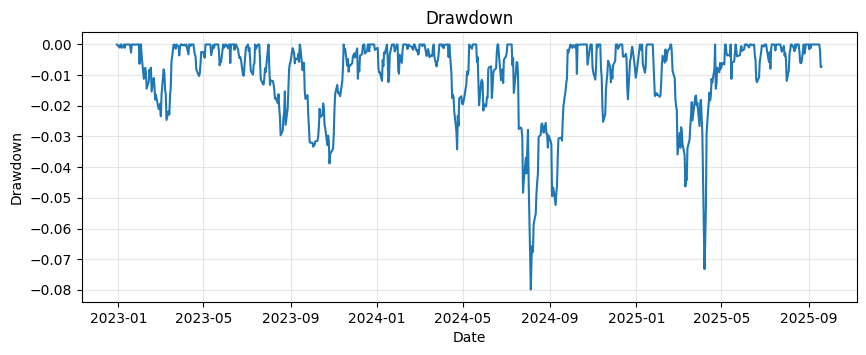

In [12]:
# -*- coding: utf-8 -*-
# Jupyter: Custom weights (by code), ANNUAL rebalance (t+1), trading-day only
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================= Global Config =================
START_DATE   = '2021-07-01'
END_DATE     = '2025-09-20'
INITIAL_CASH = 10000.0
COMMISSION   = 0.001       # 0.1% per trade
RF_ANNUAL    = 0.03        # risk-free for Sharpe / alpha
DATA_DIR     = "./data/20210701_20250920"
os.makedirs(DATA_DIR, exist_ok=True)

# 资产映射：股票代码 -> 描述名称（展示用）
ASSET_NAME_MAP = {
   
    '516780': 'EARTH_ETF',
    # '513730': 'DONGNAN_ETF',
    '159687': 'YATAI_ETF',
    '159726': 'HSHL_ETF',
    # 7 * 3 + 4 = 25
    '159934': 'GLD_ETF',
    '511260': 'GUOZAI_ETF',
    # '159985': 'DOU_ETF',
    # 25 + 15  = 40
    '159941':    'NASDAQ_ETF',
    'SPY':    'SPY_ETF'
    # 20 + 15 = 35
}
CODES = list(ASSET_NAME_MAP.keys())       # 交易/下载使用代码
CODE2NAME = ASSET_NAME_MAP.copy()         # 显示使用描述
NAME2CODE = {v:k for k,v in CODE2NAME.items()}

# ----------- 自定义权重（按股票代码填写） -----------
# 可用比例或百分比（总和≈1 或 ≈100 均可），脚本会归一化
WEIGHTS_USER = {
    '516780' : 4,
    '159687' : 8,
    '159726' : 8,
    
    '159934' : 30,
    '511260' : 20,
    
    '159941':   20,
    'SPY':    10
}
# -------------------------------------------------

# ================= Utilities: IO & Normalize =================
def csv_path(code: str) -> str:
    return os.path.join(DATA_DIR, f"{code}.csv")

def ensure_columns_ohlcv(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize to: date, open, high, low, close, volume
    - Robust to non-string / tuple column names
    - Accepts common Chinese headers
    - Drops rows without close; ensures YYYY-MM-DD for CSV
    """
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    lower_map = {c.lower(): c for c in df.columns}
    variants = {
        'date':   ['date','日期','time','交易日期'],
        'open':   ['open','开盘'],
        'high':   ['high','最高'],
        'low':    ['low','最低'],
        'close':  ['close','收盘','收盘价','收盘價','收盘价(前复权)','adj close'],
        'volume': ['volume','成交量','vol','成交量(手)']
    }
    rename = {}
    for tgt, alts in variants.items():
        hit = None
        # exact
        for alt in alts:
            al = alt.lower()
            if al in lower_map:
                hit = lower_map[al]; break
        # contains
        if hit is None:
            alts_l = [a.lower() for a in alts]
            for col in df.columns:
                cl = col.lower()
                if any(a in cl for a in alts_l):
                    hit = col; break
        if hit is not None:
            rename[hit] = tgt
    df = df.rename(columns=rename)
    # yfinance standard fallback
    upper_fb = {'Date':'date','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'}
    for k,v in upper_fb.items():
        if v not in df.columns and k in df.columns:
            df = df.rename(columns={k:v})

    keep = ['date','open','high','low','close','volume']
    df = df[[c for c in keep if c in df.columns]].copy()
    if 'date' not in df.columns:
        raise ValueError("Missing 'date' after normalization.")
    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.tz_localize(None)
    df = df.dropna(subset=['date']).sort_values('date').drop_duplicates('date', keep='last')
    for k in ['open','high','low','close','volume']:
        if k in df.columns:
            df[k] = pd.to_numeric(df[k], errors='coerce')
    if 'close' not in df.columns:
        raise ValueError("Missing 'close' after normalization.")
    df = df.dropna(subset=['close'])
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    return df

def download_akshare_etf(code: str, start: str, end: str) -> pd.DataFrame:
    import akshare as ak
    try:
        df = ak.fund_etf_hist_em(
            symbol=code, period="daily",
            start_date=start.replace('-', ''),
            end_date=end.replace('-', ''),
            adjust=""
        )
    except Exception:
        df = ak.fund_etf_hist_sina(symbol=code)
    df = ensure_columns_ohlcv(df)
    m = (df['date'] >= start) & (df['date'] <= end)
    return df.loc[m].copy()

def download_yfinance(code: str, start: str, end: str) -> pd.DataFrame:
    import yfinance as yf
    end_plus = (pd.to_datetime(end) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')  # inclusive end
    yfd = yf.download(code, start=start, end=end_plus, progress=False, auto_adjust=False)
    if yfd is None or yfd.empty:
        raise RuntimeError(f"yfinance empty for {code}")
    yfd = yfd.reset_index().rename(columns={
        'Date':'date','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'
    })
    yfd['date'] = pd.to_datetime(yfd['date']).dt.tz_localize(None)
    yfd = yfd.sort_values('date')
    yfd['date'] = yfd['date'].dt.strftime('%Y-%m-%d')
    return yfd[['date','open','high','low','close','volume']]

def load_or_download(code: str, start: str, end: str) -> pd.DataFrame:
    """Read cache; else download (digits->akshare, letters->yfinance), save CSV and return."""
    path = csv_path(code)
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            df = ensure_columns_ohlcv(df)
            m = (df['date'] >= start) & (df['date'] <= end)
            df = df.loc[m].copy()
            if not df.empty:
                return df
        except Exception:
            pass
    df = download_akshare_etf(code, start, end) if code.isdigit() else download_yfinance(code, start, end)
    df = ensure_columns_ohlcv(df)
    df.to_csv(path, index=False, columns=['date','open','high','low','close','volume'])
    return df

def normalize_weights_by_code(weights_user: dict, codes: list) -> dict:
    """Normalize user weights dict keyed by code; return dict(code->weight in [0,1], sum=1)."""
    w = pd.Series(weights_user, dtype=float).reindex(codes).fillna(0.0)
    s = w.sum()
    if s <= 0:
        w[:] = 1.0/len(codes)
        print("[Info] Provided weights sum to 0. Using equal-weight.")
    else:
        w = (w / s).clip(lower=0)
        w = w / w.sum()
    zeros = w[w==0]
    if len(zeros) > 0:
        print(f"[Warn] Zero weight for: {list(zeros.index)}")
    return w.to_dict()

WEIGHTS_CODE = normalize_weights_by_code(WEIGHTS_USER, CODES)  # 内部按代码

# ================== Data Ingestion ==================
def get_all_price_series(codes, start, end):
    data = {}
    for code in codes:
        df = load_or_download(code, start, end)
        if df.empty:
            raise RuntimeError(f"No data for {code} in {start}~{end}")
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date').sort_index()
        data[code] = df[['open','high','low','close','volume']].copy()
    return data

prices_dict = get_all_price_series(CODES, START_DATE, END_DATE)

# Global trading-day index (union of bars across all assets; no natural days)
all_trading_days = pd.Index(sorted(set().union(*[df.index for df in prices_dict.values()])))

# Close matrix aligned on global trading days; forward-fill per asset
close_code = pd.DataFrame(index=all_trading_days, columns=CODES, dtype=float)
for code, df in prices_dict.items():
    close_code.loc[df.index, code] = df['close']
close_code = close_code.ffill().dropna(how='any')
close_code = close_code.loc[
    (close_code.index >= pd.to_datetime(START_DATE)) &
    (close_code.index <= pd.to_datetime(END_DATE))
]

# 一个名字版（仅用于展示/输出；内部计算仍可按代码更稳）
close_name = close_code.rename(columns=CODE2NAME)

# ================ Annual Rebalance (t+1) ================
def first_trading_day_of_years(idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
    df = pd.DataFrame(index=idx); df['Y'] = df.index.year
    firsts = df.groupby('Y').apply(lambda x: x.index.min())
    return pd.DatetimeIndex(firsts.values)

def next_trading_day(idx: pd.DatetimeIndex, dt: pd.Timestamp):
    pos = idx.searchsorted(dt, side='right')
    return None if pos >= len(idx) else idx[pos]

year_first_days = first_trading_day_of_years(close_code.index)
trade_dates = pd.DatetimeIndex(sorted(set(filter(
    None, (next_trading_day(close_code.index, yd) for yd in year_first_days)
))))
trade_dates = trade_dates[
    (trade_dates >= close_code.index.min()) & (trade_dates <= close_code.index.max())
]

# ================ Backtest (annual t+1, fixed custom weights) ================
def run_backtest(close_df_code: pd.DataFrame, weights_code: dict,
                 trade_dates: pd.DatetimeIndex,
                 initial_cash=INITIAL_CASH, commission=COMMISSION):
    codes = list(close_df_code.columns)
    w_vec = pd.Series(weights_code).reindex(codes).fillna(0.0)

    cash = initial_cash
    shares = pd.Series(0.0, index=codes)
    equity_curve = pd.Series(index=close_df_code.index, dtype=float)
    positions_value = pd.Series(index=close_df_code.index, dtype=float)

    trade_records, period_pnls = [], []
    last_trade_nav, last_trade_date = None, None

    for dt in close_df_code.index:
        prices = close_df_code.loc[dt, codes]

        if dt in trade_dates:
            total_equity = cash + np.nansum(shares.values * prices.values)
            target_value = total_equity * w_vec
            current_value = shares * prices
            trade_value = target_value - current_value
            turnover = float(np.nansum(np.abs(trade_value.values)))
            cost = turnover * commission

            cash = cash - np.nansum(trade_value.values) - cost
            price_nonzero = prices.replace(0, np.nan)
            shares = (target_value / price_nonzero).fillna(0.0)

            trade_records.append({'date': dt, 'turnover': turnover, 'commission': float(cost)})

            if last_trade_nav is not None:
                period_return = (total_equity - last_trade_nav) / last_trade_nav
                period_pnls.append({'start': last_trade_date, 'end': dt, 'return': float(period_return)})
            last_trade_nav, last_trade_date = total_equity, dt

        port_val = float(np.nansum(shares.values * prices.values))
        positions_value[dt] = port_val
        equity_curve[dt] = cash + port_val

    if last_trade_nav is not None:
        final_nav = equity_curve.iloc[-1]
        period_return = (final_nav - last_trade_nav) / last_trade_nav
        period_pnls.append({'start': last_trade_date, 'end': equity_curve.index[-1], 'return': float(period_return)})

    daily_ret = equity_curve.pct_change().dropna()

    # Quarterly returns (quarter-end only, for reporting only)
    q_df = pd.DataFrame({'nav': equity_curve})
    q_df['Q'] = q_df.index.to_period('Q')
    q_end_nav = q_df.groupby('Q').tail(1)
    q_start_nav = q_df.groupby('Q').head(1)
    q_returns = []
    for yq, end_row in q_end_nav.groupby('Q'):
        end_nav = end_row['nav'].iloc[-1]
        start_nav = q_start_nav[q_start_nav['Q']==yq]['nav'].iloc[0]
        q_returns.append({'Quarter': str(yq), 'Return': float(end_nav/start_nav - 1.0)})
    quarterly_returns = pd.DataFrame(q_returns)

    # Annualized stats
    ann_factor   = 252.0
    total_return = equity_curve.iloc[-1] / equity_curve.iloc[0] - 1.0
    trading_days = len(daily_ret)
    ann_return   = (1.0 + total_return) ** (ann_factor / trading_days) - 1.0 if trading_days>0 else np.nan
    vol_ann      = daily_ret.std() * np.sqrt(ann_factor)
    sharpe       = ((daily_ret - RF_ANNUAL/ann_factor).mean() / daily_ret.std()) * np.sqrt(ann_factor) if daily_ret.std()>0 else np.nan

    roll_max     = equity_curve.cummax()
    max_dd       = (equity_curve/roll_max - 1.0).min()

    trades_df    = pd.DataFrame(trade_records)
    periods_df   = pd.DataFrame(period_pnls)
    num_trades   = len(trades_df)
    win_rate     = float((periods_df['return'] > 0).mean()) if not periods_df.empty else np.nan

    return {
        'equity_curve': equity_curve,
        'positions_value': positions_value,
        'daily_return': daily_ret,
        'quarterly_returns': quarterly_returns,
        'trade_records': trades_df,
        'period_returns': periods_df,
        'ann_return': ann_return,
        'total_return': total_return,
        'vol_ann': vol_ann,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'num_trades': num_trades,
        'win_rate': win_rate
    }

bt = run_backtest(close_code, WEIGHTS_CODE, trade_dates, INITIAL_CASH, COMMISSION)

# ================= Alpha vs SPY (read or download SPY.csv) =================
def load_spy_for_alpha():
    path = csv_path('SPY')
    if os.path.exists(path):
        df = pd.read_csv(path)
        df = ensure_columns_ohlcv(df)
        df['date'] = pd.to_datetime(df['date'])
        return df.set_index('date').sort_index()[['close']]
    else:
        spy = download_yfinance('SPY', START_DATE, END_DATE)
        spy.to_csv(path, index=False)
        spy['date'] = pd.to_datetime(spy['date'])
        return spy.set_index('date').sort_index()[['close']]

def calc_alpha(strategy_daily_ret: pd.Series, rf_annual=RF_ANNUAL):
    spy_df = load_spy_for_alpha()
    df = pd.DataFrame(index=strategy_daily_ret.index)
    df['ret_s'] = strategy_daily_ret.values
    df['spy_close'] = spy_df['close'].reindex(df.index).ffill()
    df['spy_ret'] = df['spy_close'].pct_change()
    df = df.dropna()
    if df.empty or df['spy_ret'].std()==0: return np.nan, np.nan
    rf_daily = rf_annual / 252.0
    xs = df['ret_s'] - rf_daily
    xm = df['spy_ret'] - rf_daily
    X = np.vstack([np.ones(len(xm)), xm.values]).T; y = xs.values
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    alpha_daily, beta = beta_hat[0], beta_hat[1]
    return alpha_daily*252.0, beta

alpha_annual, beta = calc_alpha(bt['daily_return'])

# ================= Yearly stats (YTD / per-year ann. / T12M) =================
def yearly_stats(equity: pd.Series):
    df = equity.to_frame('nav').copy(); df['year'] = df.index.year
    stats = []
    for y, grp in df.groupby('year'):
        if len(grp) < 2: continue
        ret = grp['nav'].iloc[-1] / grp['nav'].iloc[0] - 1.0
        ann = (1+ret)**(252/len(grp)) - 1.0
        stats.append({'Year': int(y), 'AnnualizedReturn': float(ann), 'TotalReturn': float(ret)})
    stats_df = pd.DataFrame(stats)
    last_year = df['year'].iloc[-1]
    ytd_grp = df[df['year']==last_year]
    ytd = ytd_grp['nav'].iloc[-1] / ytd_grp['nav'].iloc[0] - 1.0 if len(ytd_grp)>1 else np.nan
    t12m_window = equity.last('365D')
    t12m_ret = t12m_window.iloc[-1] / t12m_window.iloc[0] - 1.0 if len(t12m_window)>=2 else np.nan
    return stats_df, ytd, t12m_ret

yearly_df, ytd_ret, t12m_ret = yearly_stats(bt['equity_curve'])

# ================= Reporting tables (names, not codes) =================
# 权重表：展示为描述名称
weights_display = pd.Series(
    {CODE2NAME[c]: w for c, w in WEIGHTS_CODE.items()},
    name='Weight'
).to_frame()

# 每季度选择的基金（固定组合）：展示为描述名称
quarters_list = sorted(set(close_code.index.to_period('Q').astype(str)))
selected_each_quarter = pd.Series({q: [CODE2NAME[c] for c in CODES] for q in quarters_list})
chosen_funds_df = pd.DataFrame({'Quarter': quarters_list, 'Selected': selected_each_quarter.values})

# 汇总指标
summary = {
    'Total Annualized Return': bt['ann_return'],
    'Total Return': bt['total_return'],
    'Sharpe (Rf=3%)': bt['sharpe'],
    'Volatility (ann.)': bt['vol_ann'],
    'Max Drawdown': bt['max_drawdown'],
    'Alpha (annual)': alpha_annual,
    'Beta': beta,
    'Trades': bt['num_trades'],
    'Win Rate': bt['win_rate'],
    'YTD': ytd_ret,
    'T12M': t12m_ret
}
summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])

from IPython.display import display
display(weights_display)
display(summary_df)

print("\n== Yearly Stats =="); display(yearly_df)
print("\n== Quarterly Returns (quarter-end only) =="); display(bt['quarterly_returns'])
print("\n== Quarterly Selected Funds =="); display(chosen_funds_df)

# 交易与区间收益记录（日期仍为交易日）
print("\n== Trade Records =="); display(bt['trade_records'])
print("\n== Period Returns (between rebalances) =="); display(bt['period_returns'])

# ================= Plots (English labels; names in legends if needed) =================
plt.figure(figsize=(10,5))
plt.plot(bt['equity_curve'].index, bt['equity_curve'].values, label='Equity')
plt.title('Equity Curve'); plt.xlabel('Date'); plt.ylabel('Net Asset Value')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

roll_max = bt['equity_curve'].cummax()
drawdown = bt['equity_curve']/roll_max - 1.0
plt.figure(figsize=(10,3.5))
plt.plot(drawdown.index, drawdown.values, label='Drawdown')
plt.title('Drawdown'); plt.xlabel('Date'); plt.ylabel('Drawdown')
plt.grid(True, alpha=0.3); plt.show()


,Weight
GLD_ETF,0.3
YATAI_ETF,0.1
HSHL_ETF,0.1
GUOZAI_ETF,0.2
NASDAQ_ETF,0.2
SPY_ETF,0.1


,Value
Total Annualized Return,0.234892
Total Return,0.479682
Sharpe (Rf=3%),2.124305
Volatility (ann.),0.087019
Max Drawdown,-0.077439
Alpha (annual),0.124354
Beta,0.332143
Trades,3.000000
Win Rate,1.000000
YTD,0.189559



== Yearly Stats ==


,Year,AnnualizedReturn,TotalReturn
0,2023,0.311612,0.022862
1,2024,0.209313,0.217550
2,2025,0.263542,0.189559



== Quarterly Returns (quarter-end only) ==


,Quarter,Return
0,2023Q4,0.022862
1,2024Q1,0.077048
2,2024Q2,0.048080
3,2024Q3,0.043905
4,2024Q4,0.031974
5,2025Q1,0.038556
6,2025Q2,0.070517
7,2025Q3,0.061642



== Quarterly Selected Funds ==


,Quarter,Selected
0,2023Q4,"[GLD_ETF, YATAI_ETF, HSHL_ETF, GUOZAI_ETF, NAS..."
1,2024Q1,"[GLD_ETF, YATAI_ETF, HSHL_ETF, GUOZAI_ETF, NAS..."
2,2024Q2,"[GLD_ETF, YATAI_ETF, HSHL_ETF, GUOZAI_ETF, NAS..."
3,2024Q3,"[GLD_ETF, YATAI_ETF, HSHL_ETF, GUOZAI_ETF, NAS..."
4,2024Q4,"[GLD_ETF, YATAI_ETF, HSHL_ETF, GUOZAI_ETF, NAS..."
5,2025Q1,"[GLD_ETF, YATAI_ETF, HSHL_ETF, GUOZAI_ETF, NAS..."
6,2025Q2,"[GLD_ETF, YATAI_ETF, HSHL_ETF, GUOZAI_ETF, NAS..."
7,2025Q3,"[GLD_ETF, YATAI_ETF, HSHL_ETF, GUOZAI_ETF, NAS..."



== Trade Records ==


,date,turnover,commission
0,2023-12-04,10000.000000,10.000000
1,2024-01-03,118.286419,0.118286
2,2025-01-03,723.070459,0.723070



== Period Returns (between rebalances) ==


,start,end,return
0,2023-12-04,2024-01-03,0.016801
1,2024-01-03,2025-01-03,0.232136
2,2025-01-03,2025-09-19,0.181066


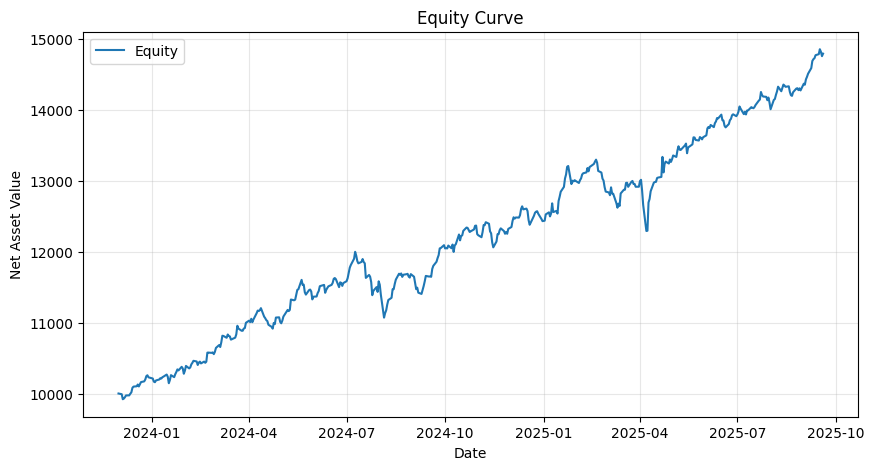

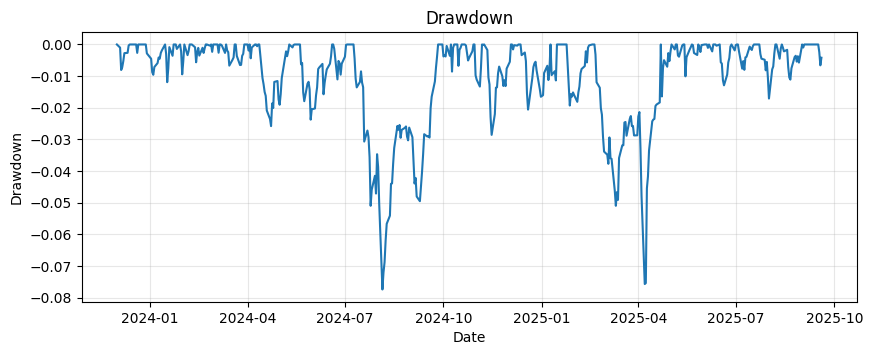

In [6]:
# -*- coding: utf-8 -*-
# Jupyter: Custom weights (by code), ANNUAL rebalance (t+1), trading-day only
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================= Global Config =================
START_DATE   = '2023-12-01'
END_DATE     = '2025-09-20'
INITIAL_CASH = 10000.0
COMMISSION   = 0.001       # 0.1% per trade
RF_ANNUAL    = 0.03        # risk-free for Sharpe / alpha
DATA_DIR     = "./data/20210701_20250910"
os.makedirs(DATA_DIR, exist_ok=True)

# 资产映射：股票代码 -> 描述名称（展示用）
ASSET_NAME_MAP = {
    # '513010': 'HSTECH_ETF',
    # '159892': 'HSDRAG_ETF',
    '159934': 'GLD_ETF',
    # '159985': 'DOU_ETF',
    # '510880': 'RED_ETF',
    # '560860': 'YOUSE_ETF',
    # '516780': 'EARTH_ETF',
    '159687': 'YATAI_ETF',
    '159726': 'HSHL_ETF',
    '511260': 'GUOZAI_ETF',
    'QQQ':    'NASDAQ_ETF',
    # "SHY": "Bonds_short",
    'SPY':    'SPY_ETF'
}
CODES = list(ASSET_NAME_MAP.keys())       # 交易/下载使用代码
CODE2NAME = ASSET_NAME_MAP.copy()         # 显示使用描述
NAME2CODE = {v:k for k,v in CODE2NAME.items()}

# ----------- 自定义权重（按股票代码填写） -----------
# 可用比例或百分比（总和≈1 或 ≈100 均可），脚本会归一化
WEIGHTS_USER = {
    # '513010': 10,
    # '159892': 10,
    '159934': 30,
    '159687': 10,
    '159726': 10,
    # '159985': 10,
    # '510880': 10,
    # '516780': 10,
    '511260': 20,
    # 'SHY':    20,
    'QQQ':    20,
    'SPY':    10
}
# -------------------------------------------------

# ================= Utilities: IO & Normalize =================
def csv_path(code: str) -> str:
    return os.path.join(DATA_DIR, f"{code}.csv")

def ensure_columns_ohlcv(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize to: date, open, high, low, close, volume
    - Robust to non-string / tuple column names
    - Accepts common Chinese headers
    - Drops rows without close; ensures YYYY-MM-DD for CSV
    """
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    lower_map = {c.lower(): c for c in df.columns}
    variants = {
        'date':   ['date','日期','time','交易日期'],
        'open':   ['open','开盘'],
        'high':   ['high','最高'],
        'low':    ['low','最低'],
        'close':  ['close','收盘','收盘价','收盘價','收盘价(前复权)','adj close'],
        'volume': ['volume','成交量','vol','成交量(手)']
    }
    rename = {}
    for tgt, alts in variants.items():
        hit = None
        # exact
        for alt in alts:
            al = alt.lower()
            if al in lower_map:
                hit = lower_map[al]; break
        # contains
        if hit is None:
            alts_l = [a.lower() for a in alts]
            for col in df.columns:
                cl = col.lower()
                if any(a in cl for a in alts_l):
                    hit = col; break
        if hit is not None:
            rename[hit] = tgt
    df = df.rename(columns=rename)
    # yfinance standard fallback
    upper_fb = {'Date':'date','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'}
    for k,v in upper_fb.items():
        if v not in df.columns and k in df.columns:
            df = df.rename(columns={k:v})

    keep = ['date','open','high','low','close','volume']
    df = df[[c for c in keep if c in df.columns]].copy()
    if 'date' not in df.columns:
        raise ValueError("Missing 'date' after normalization.")
    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.tz_localize(None)
    df = df.dropna(subset=['date']).sort_values('date').drop_duplicates('date', keep='last')
    for k in ['open','high','low','close','volume']:
        if k in df.columns:
            df[k] = pd.to_numeric(df[k], errors='coerce')
    if 'close' not in df.columns:
        raise ValueError("Missing 'close' after normalization.")
    df = df.dropna(subset=['close'])
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    return df

def download_akshare_etf(code: str, start: str, end: str) -> pd.DataFrame:
    import akshare as ak
    try:
        df = ak.fund_etf_hist_em(
            symbol=code, period="daily",
            start_date=start.replace('-', ''),
            end_date=end.replace('-', ''),
            adjust=""
        )
    except Exception:
        df = ak.fund_etf_hist_sina(symbol=code)
    df = ensure_columns_ohlcv(df)
    m = (df['date'] >= start) & (df['date'] <= end)
    return df.loc[m].copy()

def download_yfinance(code: str, start: str, end: str) -> pd.DataFrame:
    import yfinance as yf
    end_plus = (pd.to_datetime(end) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')  # inclusive end
    yfd = yf.download(code, start=start, end=end_plus, progress=False, auto_adjust=False)
    if yfd is None or yfd.empty:
        raise RuntimeError(f"yfinance empty for {code}")
    yfd = yfd.reset_index().rename(columns={
        'Date':'date','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'
    })
    yfd['date'] = pd.to_datetime(yfd['date']).dt.tz_localize(None)
    yfd = yfd.sort_values('date')
    yfd['date'] = yfd['date'].dt.strftime('%Y-%m-%d')
    return yfd[['date','open','high','low','close','volume']]

def load_or_download(code: str, start: str, end: str) -> pd.DataFrame:
    """Read cache; else download (digits->akshare, letters->yfinance), save CSV and return."""
    path = csv_path(code)
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            df = ensure_columns_ohlcv(df)
            m = (df['date'] >= start) & (df['date'] <= end)
            df = df.loc[m].copy()
            if not df.empty:
                return df
        except Exception:
            pass
    df = download_akshare_etf(code, start, end) if code.isdigit() else download_yfinance(code, start, end)
    df = ensure_columns_ohlcv(df)
    df.to_csv(path, index=False, columns=['date','open','high','low','close','volume'])
    return df

def normalize_weights_by_code(weights_user: dict, codes: list) -> dict:
    """Normalize user weights dict keyed by code; return dict(code->weight in [0,1], sum=1)."""
    w = pd.Series(weights_user, dtype=float).reindex(codes).fillna(0.0)
    s = w.sum()
    if s <= 0:
        w[:] = 1.0/len(codes)
        print("[Info] Provided weights sum to 0. Using equal-weight.")
    else:
        w = (w / s).clip(lower=0)
        w = w / w.sum()
    zeros = w[w==0]
    if len(zeros) > 0:
        print(f"[Warn] Zero weight for: {list(zeros.index)}")
    return w.to_dict()

WEIGHTS_CODE = normalize_weights_by_code(WEIGHTS_USER, CODES)  # 内部按代码

# ================== Data Ingestion ==================
def get_all_price_series(codes, start, end):
    data = {}
    for code in codes:
        df = load_or_download(code, start, end)
        if df.empty:
            raise RuntimeError(f"No data for {code} in {start}~{end}")
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date').sort_index()
        data[code] = df[['open','high','low','close','volume']].copy()
    return data

prices_dict = get_all_price_series(CODES, START_DATE, END_DATE)

# Global trading-day index (union of bars across all assets; no natural days)
all_trading_days = pd.Index(sorted(set().union(*[df.index for df in prices_dict.values()])))

# Close matrix aligned on global trading days; forward-fill per asset
close_code = pd.DataFrame(index=all_trading_days, columns=CODES, dtype=float)
for code, df in prices_dict.items():
    close_code.loc[df.index, code] = df['close']
close_code = close_code.ffill().dropna(how='any')
close_code = close_code.loc[
    (close_code.index >= pd.to_datetime(START_DATE)) &
    (close_code.index <= pd.to_datetime(END_DATE))
]

# 一个名字版（仅用于展示/输出；内部计算仍可按代码更稳）
close_name = close_code.rename(columns=CODE2NAME)

# ================ Annual Rebalance (t+1) ================
def first_trading_day_of_years(idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
    df = pd.DataFrame(index=idx); df['Y'] = df.index.year
    firsts = df.groupby('Y').apply(lambda x: x.index.min())
    return pd.DatetimeIndex(firsts.values)

def next_trading_day(idx: pd.DatetimeIndex, dt: pd.Timestamp):
    pos = idx.searchsorted(dt, side='right')
    return None if pos >= len(idx) else idx[pos]

year_first_days = first_trading_day_of_years(close_code.index)
trade_dates = pd.DatetimeIndex(sorted(set(filter(
    None, (next_trading_day(close_code.index, yd) for yd in year_first_days)
))))
trade_dates = trade_dates[
    (trade_dates >= close_code.index.min()) & (trade_dates <= close_code.index.max())
]

# ================ Backtest (annual t+1, fixed custom weights) ================
def run_backtest(close_df_code: pd.DataFrame, weights_code: dict,
                 trade_dates: pd.DatetimeIndex,
                 initial_cash=INITIAL_CASH, commission=COMMISSION):
    codes = list(close_df_code.columns)
    w_vec = pd.Series(weights_code).reindex(codes).fillna(0.0)

    cash = initial_cash
    shares = pd.Series(0.0, index=codes)
    equity_curve = pd.Series(index=close_df_code.index, dtype=float)
    positions_value = pd.Series(index=close_df_code.index, dtype=float)

    trade_records, period_pnls = [], []
    last_trade_nav, last_trade_date = None, None

    for dt in close_df_code.index:
        prices = close_df_code.loc[dt, codes]

        if dt in trade_dates:
            total_equity = cash + np.nansum(shares.values * prices.values)
            target_value = total_equity * w_vec
            current_value = shares * prices
            trade_value = target_value - current_value
            turnover = float(np.nansum(np.abs(trade_value.values)))
            cost = turnover * commission

            cash = cash - np.nansum(trade_value.values) - cost
            price_nonzero = prices.replace(0, np.nan)
            shares = (target_value / price_nonzero).fillna(0.0)

            trade_records.append({'date': dt, 'turnover': turnover, 'commission': float(cost)})

            if last_trade_nav is not None:
                period_return = (total_equity - last_trade_nav) / last_trade_nav
                period_pnls.append({'start': last_trade_date, 'end': dt, 'return': float(period_return)})
            last_trade_nav, last_trade_date = total_equity, dt

        port_val = float(np.nansum(shares.values * prices.values))
        positions_value[dt] = port_val
        equity_curve[dt] = cash + port_val

    if last_trade_nav is not None:
        final_nav = equity_curve.iloc[-1]
        period_return = (final_nav - last_trade_nav) / last_trade_nav
        period_pnls.append({'start': last_trade_date, 'end': equity_curve.index[-1], 'return': float(period_return)})

    daily_ret = equity_curve.pct_change().dropna()

    # Quarterly returns (quarter-end only, for reporting only)
    q_df = pd.DataFrame({'nav': equity_curve})
    q_df['Q'] = q_df.index.to_period('Q')
    q_end_nav = q_df.groupby('Q').tail(1)
    q_start_nav = q_df.groupby('Q').head(1)
    q_returns = []
    for yq, end_row in q_end_nav.groupby('Q'):
        end_nav = end_row['nav'].iloc[-1]
        start_nav = q_start_nav[q_start_nav['Q']==yq]['nav'].iloc[0]
        q_returns.append({'Quarter': str(yq), 'Return': float(end_nav/start_nav - 1.0)})
    quarterly_returns = pd.DataFrame(q_returns)

    # Annualized stats
    ann_factor   = 252.0
    total_return = equity_curve.iloc[-1] / equity_curve.iloc[0] - 1.0
    trading_days = len(daily_ret)
    ann_return   = (1.0 + total_return) ** (ann_factor / trading_days) - 1.0 if trading_days>0 else np.nan
    vol_ann      = daily_ret.std() * np.sqrt(ann_factor)
    sharpe       = ((daily_ret - RF_ANNUAL/ann_factor).mean() / daily_ret.std()) * np.sqrt(ann_factor) if daily_ret.std()>0 else np.nan

    roll_max     = equity_curve.cummax()
    max_dd       = (equity_curve/roll_max - 1.0).min()

    trades_df    = pd.DataFrame(trade_records)
    periods_df   = pd.DataFrame(period_pnls)
    num_trades   = len(trades_df)
    win_rate     = float((periods_df['return'] > 0).mean()) if not periods_df.empty else np.nan

    return {
        'equity_curve': equity_curve,
        'positions_value': positions_value,
        'daily_return': daily_ret,
        'quarterly_returns': quarterly_returns,
        'trade_records': trades_df,
        'period_returns': periods_df,
        'ann_return': ann_return,
        'total_return': total_return,
        'vol_ann': vol_ann,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'num_trades': num_trades,
        'win_rate': win_rate
    }

bt = run_backtest(close_code, WEIGHTS_CODE, trade_dates, INITIAL_CASH, COMMISSION)

# ================= Alpha vs SPY (read or download SPY.csv) =================
def load_spy_for_alpha():
    path = csv_path('SPY')
    if os.path.exists(path):
        df = pd.read_csv(path)
        df = ensure_columns_ohlcv(df)
        df['date'] = pd.to_datetime(df['date'])
        return df.set_index('date').sort_index()[['close']]
    else:
        spy = download_yfinance('SPY', START_DATE, END_DATE)
        spy.to_csv(path, index=False)
        spy['date'] = pd.to_datetime(spy['date'])
        return spy.set_index('date').sort_index()[['close']]

def calc_alpha(strategy_daily_ret: pd.Series, rf_annual=RF_ANNUAL):
    spy_df = load_spy_for_alpha()
    df = pd.DataFrame(index=strategy_daily_ret.index)
    df['ret_s'] = strategy_daily_ret.values
    df['spy_close'] = spy_df['close'].reindex(df.index).ffill()
    df['spy_ret'] = df['spy_close'].pct_change()
    df = df.dropna()
    if df.empty or df['spy_ret'].std()==0: return np.nan, np.nan
    rf_daily = rf_annual / 252.0
    xs = df['ret_s'] - rf_daily
    xm = df['spy_ret'] - rf_daily
    X = np.vstack([np.ones(len(xm)), xm.values]).T; y = xs.values
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    alpha_daily, beta = beta_hat[0], beta_hat[1]
    return alpha_daily*252.0, beta

alpha_annual, beta = calc_alpha(bt['daily_return'])

# ================= Yearly stats (YTD / per-year ann. / T12M) =================
def yearly_stats(equity: pd.Series):
    df = equity.to_frame('nav').copy(); df['year'] = df.index.year
    stats = []
    for y, grp in df.groupby('year'):
        if len(grp) < 2: continue
        ret = grp['nav'].iloc[-1] / grp['nav'].iloc[0] - 1.0
        ann = (1+ret)**(252/len(grp)) - 1.0
        stats.append({'Year': int(y), 'AnnualizedReturn': float(ann), 'TotalReturn': float(ret)})
    stats_df = pd.DataFrame(stats)
    last_year = df['year'].iloc[-1]
    ytd_grp = df[df['year']==last_year]
    ytd = ytd_grp['nav'].iloc[-1] / ytd_grp['nav'].iloc[0] - 1.0 if len(ytd_grp)>1 else np.nan
    t12m_window = equity.last('365D')
    t12m_ret = t12m_window.iloc[-1] / t12m_window.iloc[0] - 1.0 if len(t12m_window)>=2 else np.nan
    return stats_df, ytd, t12m_ret

yearly_df, ytd_ret, t12m_ret = yearly_stats(bt['equity_curve'])

# ================= Reporting tables (names, not codes) =================
# 权重表：展示为描述名称
weights_display = pd.Series(
    {CODE2NAME[c]: w for c, w in WEIGHTS_CODE.items()},
    name='Weight'
).to_frame()

# 每季度选择的基金（固定组合）：展示为描述名称
quarters_list = sorted(set(close_code.index.to_period('Q').astype(str)))
selected_each_quarter = pd.Series({q: [CODE2NAME[c] for c in CODES] for q in quarters_list})
chosen_funds_df = pd.DataFrame({'Quarter': quarters_list, 'Selected': selected_each_quarter.values})

# 汇总指标
summary = {
    'Total Annualized Return': bt['ann_return'],
    'Total Return': bt['total_return'],
    'Sharpe (Rf=3%)': bt['sharpe'],
    'Volatility (ann.)': bt['vol_ann'],
    'Max Drawdown': bt['max_drawdown'],
    'Alpha (annual)': alpha_annual,
    'Beta': beta,
    'Trades': bt['num_trades'],
    'Win Rate': bt['win_rate'],
    'YTD': ytd_ret,
    'T12M': t12m_ret
}
summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])

from IPython.display import display
display(weights_display)
display(summary_df)

print("\n== Yearly Stats =="); display(yearly_df)
print("\n== Quarterly Returns (quarter-end only) =="); display(bt['quarterly_returns'])
print("\n== Quarterly Selected Funds =="); display(chosen_funds_df)

# 交易与区间收益记录（日期仍为交易日）
print("\n== Trade Records =="); display(bt['trade_records'])
print("\n== Period Returns (between rebalances) =="); display(bt['period_returns'])

# ================= Plots (English labels; names in legends if needed) =================
plt.figure(figsize=(10,5))
plt.plot(bt['equity_curve'].index, bt['equity_curve'].values, label='Equity')
plt.title('Equity Curve'); plt.xlabel('Date'); plt.ylabel('Net Asset Value')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

roll_max = bt['equity_curve'].cummax()
drawdown = bt['equity_curve']/roll_max - 1.0
plt.figure(figsize=(10,3.5))
plt.plot(drawdown.index, drawdown.values, label='Drawdown')
plt.title('Drawdown'); plt.xlabel('Date'); plt.ylabel('Drawdown')
plt.grid(True, alpha=0.3); plt.show()
